In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#PDFs in BDT and sindec?
import os

# set env flags to catch BLAS used for scipy/numpy 
# to only use 1 cpu, n_cpus will be totally controlled by csky
if False:
    os.environ['MKL_NUM_THREADS'] = "1"
    os.environ['NUMEXPR_NUM_THREADS'] = "1"
    os.environ['OMP_NUM_THREADS'] = "1"
    os.environ['OPENBLAS_NUM_THREADS'] = "1"
    os.environ['VECLIB_MAXIMUM_THREADS'] = "1"

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['savefig.facecolor'] = 'w'
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import csky as cy
from csky import cext
import numpy as np
import astropy
#from icecube import astro
import histlite as hl
import healpy
import healpy as hp
import socket
import pickle
import copy
from scipy import stats
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1 import make_axes_locatable

healpy.disable_warnings()
plt.rc('figure', facecolor = 'w')
plt.rc('figure', dpi=100)

## Define Settings

In [2]:
selection_version = 'version-001-p01'

host_name = socket.gethostname()
embargo_label = False
if 'cobalt' in host_name:
    print('Working on Cobalts')
    data_prefix = '/data/user/ssclafani/data/cscd/final'
    ana_dir = '/data/user/ssclafani/data/analyses/'
    if embargo_label:
        plot_dir = cy.utils.ensure_dir('/home/ssclafani/plots/paperplots_embargo/Fig1')    
    else:
        #plot_dir = cy.utils.ensure_dir('/home/ssclafani/plots/paperplots/Fig1')  
        plot_dir = cy.utils.ensure_dir('/home/ssclafani/public_html/Publications/GP/paperplots')
else:
    raise ValueError('Unknown host:', host_name)

Working on Cobalts


In [3]:
for dir_path in [plot_dir]:
    if not os.path.exists(dir_path):
        print('Creating directory:', dir_path)
        os.makedirs(dir_path)

## Load Data

In [4]:
repo = cy.selections.Repository()
specs = cy.selections.DNNCascadeDataSpecs.DNNC_10yr

In [5]:
%%time

ana = cy.get_analysis(
    repo, selection_version, specs, 
    #gammas=np.r_[0.1:6.01:0.125],
)

Setting up Analysis for:
DNNCascade_10yr
Setting up DNNCascade_10yr...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p01/GRL/IC86

In [6]:
a = ana.anas[0]
a.sig

Events(398873 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent, xdec, xra, true_dec, true_energy, true_ra, oneweight)

In [7]:
a.bg_data

Events(59592 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent)

## Helpers

In [8]:
from cycler import cycle
from copy import deepcopy

soft_colors = cy.plotting.soft_colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def get_bias_allt(tr, ntrials=200, n_sigs=np.r_[:101:10], quiet=False):
    trials = [
        (None if quiet else print(f'\r{n_sig:4d} ...', end='', flush=True))
        or
        tr.get_many_fits(ntrials, n_sig=n_sig, logging=False, seed=n_sig)
        for n_sig in n_sigs]
    if not quiet:
        print()
    for (n_sig, t) in zip(n_sigs, trials):
        t['ntrue'] = np.repeat(n_sig, len(t))
    allt = cy.utils.Arrays.concatenate(trials)
    return allt

def get_color_cycler():
    return cycle(colors)

def plot_ns_bias(ax, tr, allt, label=''):

    n_sigs = np.unique(allt.ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)

    h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(ax.set_ylim(lim))
    ax.plot(lim, lim, **expect_kw)
    ax.set_aspect('equal')

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$n_s$')
    ax.grid()

def plot_gamma_bias(ax, tr, allt, label=''):

    n_sigs = np.unique(allt.ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
    expect_gamma = tr.sig_injs[0].flux[0].gamma

    h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(lim)
    ax.set_ylim(1, 4)
    ax.axhline(expect_gamma, **expect_kw)

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$\gamma$')
    ax.grid()

def plot_bkg_trials(
            bg, fig=None, ax=None, 
            label='{} bg trials', 
            label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$', 
            color=colors[0],
            density=False,
            bins=50,
        ):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    if density:
        h = bg.get_hist(bins=bins).normalize()
    else:
        h = bg.get_hist(bins=bins)
    if label is not None:
        label = label.format(bg.n_total)
    hl.plot1d(ax, h, crosses=True, color=color, label=label)

    # compare with the chi2 fit:
    if hasattr(bg, 'pdf'):
        x = h.centers[0]
        norm = h.integrate().values
        if label_fit is not None:
            label_fit = label_fit.format(bg.ndof, bg.eta)
        if density:
            ax.semilogy(x, bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)
        else:
            ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)

    ax.set_xlabel(r'TS')
    if density:
        ax.set_ylabel(r'Density')
    else:
        ax.set_ylabel(r'number of trials')
    ax.legend()
        
    return fig, ax

## Setup Analysis

In [9]:
import sys
sys.path.insert(0, '../..')

import config as cg

cg.base_dir = '/data/user/ssclafani/data/analyses/unblinding_v1.0.1_csky_bugfix_template_flux/'

Running as User: ssclafani on Hostname: cobalt08.icecube.wisc.edu


In [10]:
def get_gp_tr(template_str, cutoff=np.inf, gamma=None, cpus=20):
    cutoff_GeV = cutoff * 1e3
    gp_conf = cg.get_gp_conf(
        template_str=template_str, gamma=gamma, cutoff_GeV=cutoff_GeV, base_dir=cg.base_dir)
    tr = cy.get_trial_runner(gp_conf, ana=ana, mp_cpus=cpus)
    return tr

'''def get_template_tr(template, gamma=2.7, cutoff_tev=np.inf, cpus=20):
    cutoff_gev = cutoff_tev * 1000.
    gp_conf = {
        'template': template,
        'flux': cy.hyp.PowerLawFlux(gamma, energy_cutoff=cutoff_gev),
        'randomize': ['ra'],
        'fitter_args': dict(gamma=gamma),
        'sigsub': True,
        'update_bg': True,
        'fast_weight': False,
    }
    tr = cy.get_trial_runner(gp_conf, ana=ana, mp_cpus=cpus)
    return tr
'''

"def get_template_tr(template, gamma=2.7, cutoff_tev=np.inf, cpus=20):\n    cutoff_gev = cutoff_tev * 1000.\n    gp_conf = {\n        'template': template,\n        'flux': cy.hyp.PowerLawFlux(gamma, energy_cutoff=cutoff_gev),\n        'randomize': ['ra'],\n        'fitter_args': dict(gamma=gamma),\n        'sigsub': True,\n        'update_bg': True,\n        'fast_weight': False,\n    }\n    tr = cy.get_trial_runner(gp_conf, ana=ana, mp_cpus=cpus)\n    return tr\n"

#### Get TrialRunners

In [11]:
tr_dict = {
    'pi0': get_gp_tr('pi0'),
    'kra5': get_gp_tr('kra5'),
    'kra50': get_gp_tr('kra50'),
}

Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...
<- /data/user/ssclafani/data/analyses/unblinding_v1.0.1_csky_bugfix_template_flux//templates/pi0/gamma/2.700/DNNCascade_10yr.template.npy    
Restore successful.
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/KRA-gamma_5PeV_maps_energies.tuple.npy ...
<- /data/user/ssclafani/data/analyses/unblinding_v1.0.1_csky_bugfix_template_flux//templates/kra5/DNNCascade_10yr.template.npy    
Restore successful.
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/KRA-gamma_maps_energies.tuple.npy ...
<- /data/user/ssclafani/data/analyses/unblinding_v1.0.1_csky_bugfix_template_flux//templates/kra50/DNNCascade_10yr.template.npy    
Restore successful.


#### Get Results for each template

In [12]:
res_dict = {}
for key in tr_dict.keys():
    f_path = os.path.join(
        '/data/user/mhuennefeld/data/analyses/unblinding_v1.0.1_csky_bugfix_template_flux/'
        'gp/results/{}/{}_unblinded.npy'.format(key, key), 
    )
    res_dict[key] = np.load(f_path)

#### Print best fit fluxes

In [13]:

dNdE = tr_dict['pi0'].to_dNdE(ns=res_dict['pi0'][1], E0=1e5)
E2dNdE = tr_dict['pi0'].to_E2dNdE(ns=res_dict['pi0'][1], E0=100, unit=1e3)
print(dNdE, E2dNdE)


2.4368317158544137e-18 2.4368317158544134e-11


In [14]:
ss_results = np.load(
    os.path.join(
        '/data/user/mhuennefeld/data/analyses/unblinding_v1.0.1_csky_bugfix_template_flux/', 'skyscan/results/unblinded_skyscan.npy'),
    allow_pickle=True,
)[()]
ss_trial = ss_results['ss_trial']



In [15]:
ss_results


{'ss_trial': array([[0.10876381, 0.10876381, 0.10876381, ..., 0.15437915, 0.15437915,
         0.15437915],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 'ipix_max_north': 68832,
 'ipix_max_south': 174637,
 'pval_north': 0.2801400700350175,
 'pval_south': 0.46023011505752875,
 'pval_north_nsigma': 0.5824254545557265,
 'pval_south_nsigma': 0.099854007961143}

In [16]:
# https://www.nasa.gov/mission_pages/GLAST/news/gammaray_best.html
# https://www.nasa.gov/images/content/317870main_Fermi_3_month_labeled_new.jpg
fermi_sources = {
    # ra, dec
    'NGC 1275': (049.9506656698585, +41.5116983765094),
    '3C 454.3': (343.49061658, +16.14821142),
    '47 Tuc': (006.022329, -72.081444),
    '0FGL J1813.5-1248': (273.349033, -12.766842),
    '0FGL J0614.3-3330': (093.5431162, -33.4983656),
    'PKS 0727-115': (112.57963530917, -11.68683347528),
    'Vela': (128.5000, -45.8333),
    'Geminga': (098.475638, +17.770253),
    'Crab': (083.63308, +22.01450),
    'LSI +61 303': (040.1319341179735, +61.2293308716971),
    'PSR J1836+5925': (279.056921, +59.424936),
    'PKS 1502+106': (226.10408242258, +10.49422183753),
    #'Cygnus X-3': (308.10742, +40.95775),
}

cat_dict = {}
for cat_str in ['pwn', 'snr', 'unid']:
    catalog_file = os.path.join(
        cg.catalog_dir, '{}_ESTES_12.pickle'.format(cat_str))
    cat_dict[cat_str] = np.load(catalog_file, allow_pickle=True)


#### Plot template contours

In [17]:
class ContourSkymap:
    def __init__(self, skymap, nside=None):
        
        # upscale skymap
        if nside is not None:
            skymap = hp.ud_grade(skymap, nside_out=nside)
        else:
            nside = hp.get_nside(skymap)
        
        # normalize such that sum of pixel values equals one
        self.prob_values = skymap / np.sum(skymap)
        self.neg_llh_values = -np.log10(self.prob_values)
        self.nside = hp.get_nside(self.prob_values)
        self.npix = hp.nside2npix(self.nside)
        
        self.theta, self.phi = self.get_healpix_grid()
        
        # sort healpix points according to neg llh
        sorted_indices = np.argsort(self.neg_llh_values)
        self.theta_s = self.theta[sorted_indices]
        self.phi_s = self.phi[sorted_indices]
        self.neg_llh_values_s = self.neg_llh_values[sorted_indices]
        self.prob_values_s = self.prob_values[sorted_indices]
    
        self.cdf_values_s = np.cumsum(self.prob_values_s)
    
    def get_healpix_grid(self):
        npix = hp.nside2npix(self.nside)
        theta, phi = hp.pix2ang(self.nside, np.r_[:npix])
        return theta, phi
    
    def quantile_to_pdf_value(self, quantile):
        """Get pixel probability value
        """
        assert quantile >= 0., quantile
        assert quantile <= 1., quantile

        index = np.searchsorted(self.cdf_values_s, quantile)
        return self.prob_values_s[index]
    
    def _get_level_indices(self, level=0.5, delta=0.01):
        """Get indices of healpix map, which belong to the specified
        contour as defined by: level +- delta.

        Parameters
        ----------
        level : float, optional
            The contour level. Example: a level of 0.7 means that 70% of events
            are within this contour.
        delta : float, optional
            The contour is provided by selecting directions from the sampled
            ones which have cdf values within [level - delta, level + delta].
            The smaller delta, the more accurate the contour will be. However,
            the number of available sample points for the contour will also
            decrease.

        Returns
        -------
        int, int
            The starting and stopping index for a slice of sampled events
            that lie within the contour [level - delta, level + delta].

        Raises
        ------
        ValueError
            If number of resulting samples is too low.
        """
        assert level >= 0., level
        assert level <= 1., level

        index_min = np.searchsorted(self.cdf_values_s, level - delta)
        index_max = min(self.npix,
                        np.searchsorted(self.cdf_values_s, level + delta))

        if index_max - index_min <= 10:
            raise ValueError('Number of samples is too low!')

        return index_min, index_max
    
    def contour(self, level=0.5, delta=0.01):
        """Get zenith/azimuth paris of points that lie with the specified
        contour [level - delta, level + delta].

        Parameters
        ----------
        level : float, optional
            The contour level. Example: a level of 0.7 means that 70% of events
            are within this contour.
        delta : float, optional
            The contour is provided by selecting directions from the sampled
            ones which have cdf values within [level - delta, level + delta].
            The smaller delta, the more accurate the contour will be. However,
            the number of available sample points for the contour will also
            decrease.

        Returns
        -------
        np.array, np.array
            The theta/phi pairs that lie within the contour
            [level - delta, level + delta].
        """
        index_min, index_max = self._get_level_indices(level, delta)
        return (self.theta_s[index_min:index_max],
                self.phi_s[index_min:index_max])

In [18]:
def get_smeared_template(key, smearing=5):
    space_pdf = tr_dict[key].llh_models[0].pdf_ratio_model.models[0]
    sigma_idx = np.searchsorted(np.rad2deg(space_pdf.sigmas), smearing)
    template_smeared = space_pdf.pdf_space_sig[sigma_idx]
    return np.array(template_smeared)


#### Skymap Plotting Class

In [19]:
import utils
sys.path.insert(0, '../unblinding')
import contour_compute


class SkymapPlotter:
    
    def __init__(self, fermi_sources=fermi_sources, cat_dict=cat_dict, ss_results=ss_results, **kwargs):
        self.cat_dict = cat_dict
        self.fermi_sources = fermi_sources
        self.ss_results = ss_results
        self.coord = None
        
        self.fig, self.ax, self.sp, self.cb, self.mesh = self.plot_skymap(**kwargs)
    
    def add_skymap_layer(self, m, ax=None, **kw):
        if ax is None:
            ax = self.ax
        lat, lon, Z = self.sp.map_to_latlonz(m)
        pc = ax.pcolormesh(lon, lat, Z, **kw)
        return pc
        
    @staticmethod
    def plot_skymap(
                skymap, fig=None, ax=None, outfile=None, figsize=(9, 6),
                vmin=None, vmax=None, label=None, norm=None,
                cmap=cy.plotting.skymap_cmap,
                input_coord='C',
                n_cb_ticks=5,
                gp_kw=dict(color='.3', alpha=0.5), gp_lw=1.,
                plot_gp=True, annotate=True,
                **kwargs
            ):
        """Plot a skymap

        Parameters
        ----------
        skymap : array_like
            The skymap to plot.
        outfile : str, optional
            The output file path to which to plot if provided.
        vmin : float, optional
            The minimum value for the colorbar.
        vmax : float, optional
            The maximum value for the colorbar.
        figsize : tuple, optional
            The figure size to use.
        label : str, optional
            The label for the colorbar.

        Returns
        -------
        fig, ax
            The matplotlib figure and axis.
        """
        if fig is None:
            fig, ax = plt.subplots(
                 figsize=figsize)

        if 'coord' in kwargs and kwargs['coord'] == 'G':
            nohr = True
            if input_coord == 'C':
                skymap = SkymapPlotter.equatorial_to_galactic(skymap)
        else:
            nohr = False

        sp = cy.plotting.SkyPlotter(
            pc_kw=dict(cmap=cmap, vmin=vmin, vmax=vmax, norm=norm), 
            **kwargs
        )
        mesh, cb = sp.plot_map(ax, skymap, n_ticks=n_cb_ticks, nohr=nohr, 
                               pc_kw={"edgecolor" : 'k', 'linewidth' : 0.0, 'rasterized' : True},
                              cb_kw = {'orientation' : 'vertical'})
        #cb(pad=5)
        SkymapPlotter.annotate_skymap(
            ax=ax, sp=sp, annotate=annotate, plot_gp=plot_gp, gp_kw=gp_kw, gp_lw=gp_lw,
        )
        if False:
            if sp.coord == 'G' and annotate:
                kw = dict(xycoords='axes fraction', textcoords='offset pixels', verticalalignment='center')
                #ax.annotate(r'l = -180°', xy=(1, .5), xytext=(10, 0), horizontalalignment='left', **kw)
                #ax.annotate(r'l = 180°', xy=(0, .5), xytext=(-10, 0), horizontalalignment='right', **kw)

            if sp.coord != 'G' and plot_gp:
                sp.plot_gp(ax, lw=gp_lw, **gp_kw)
                sp.plot_gc(ax, **gp_kw)
            kw = dict(color='.5', alpha=.5)
            #ax.grid(**kw)
        cb.set_label(label)
        
        #print(cb.keys())
        #ax.set_xticks(np.radians([0,90,120,180,270,360]))
        #ax.set_ylim(np.radians(-15), np.radians(15))
        #ax.set_yticks(np.radians([-15,0,15]))
        #fig.tight_layout()
        #if outfile is not None:
        #    fig.savefig(outfile)

        return fig, ax, sp, cb, mesh
    
    def get_axs(self):
        return fig, ax
    @staticmethod
    def annotate_skymap(ax, sp, annotate=True, plot_gp=True, gp_kw=dict(color='.3', alpha=0.5), gp_lw=1.):
        if sp.coord == 'G' and annotate:
            kw = dict(xycoords='axes fraction', textcoords='offset pixels', verticalalignment='center')
            #ax.annotate(r'l = -180°', xy=(1, .5-30/180), xytext=(10, 0), horizontalalignment='left', **kw)
            #ax.annotate(r'l = 180°', xy=(0, .5-30/180), xytext=(-10, 0), horizontalalignment='right', **kw)
        
        if sp.coord != 'G' and plot_gp:
            sp.plot_gp(ax, lw=gp_lw, **gp_kw)
            sp.plot_gc(ax, **gp_kw)
        kw = dict(color='.5', alpha=.5)
        ax.grid(**kw)
    
    @staticmethod
    def equatorial_to_galactic(m, rot=180):
        r = hp.Rotator(rot=rot, coord='CG')
        return r.rotate_map_pixel(m)

    @staticmethod
    def equatorial_to_galactic_coords(theta, phi, rot=180):
        r = hp.Rotator(rot=rot, coord='CG')
        return r(theta, phi)
    
    def convert_theta_phi_to_mpl_coords(self, theta, phi, convert=True):
        if self.sp.coord == 'G' and convert:
            theta, phi = self.equatorial_to_galactic_coords(theta, phi)
        x, y = self.sp.thetaphi_to_mpl(theta, phi)
        return x, y
        
    def convert_ra_dec_to_mpl_coords(self, ra, dec):
        theta = np.pi/2. - dec
        phi = ra
        return self.convert_theta_phi_to_mpl_coords(theta=theta, phi=phi)

    def draw_equator(self, ax=None, color='0.6', s=1, **kwargs):
        if ax is None:
            ax = self.ax
        phi = np.linspace(0., 2*np.pi, 10000)
        dec = np.zeros_like(phi)
        x, y = self.convert_ra_dec_to_mpl_coords(ra=phi, dec=dec)
        return ax.scatter(x, y, marker='.', color=color, s=s)

    def plot_catalog(self, ax=None, sp=None, marker='x', color='red'):
        
        if ax is None:
            ax = self.ax
        if sp is None:
            sp = self.sp
            
        for cat_str, cat in self.cat_dict.items():
            x, y = self.convert_ra_dec_to_mpl_coords(
                ra=np.deg2rad(cat.ra_deg), dec=np.deg2rad(cat.dec_deg))
            ax.scatter(x, y, marker=marker, color=color, label=cat_str)
    
    def plot_hotspots(self, ax=None, sp=None, marker='x', color='0.8', **kwargs):
        if ax is None:
            ax = self.ax
        if sp is None:
            sp = self.sp
            
        # plot hottest spots
        for res_str in ['ipix_max_north', 'ipix_max_south']:
            theta, phi = hp.pix2ang(128, self.ss_results[res_str])
            x, y = self.convert_theta_phi_to_mpl_coords(theta=theta, phi=phi)
            ax.scatter(x, y, marker=marker, color=color, **kwargs)
    
    def plot_fermi_sources(self, ax=None, sp=None, marker='+', color='1.0'):
        
        if ax is None:
            ax = self.ax
        if sp is None:
            sp = self.sp
            
        for key, (ra_deg, dec_deg) in self.fermi_sources.items():
            x, y = self.convert_ra_dec_to_mpl_coords(
                ra=np.deg2rad(ra_deg), dec=np.deg2rad(dec_deg))
            ax.scatter(x, y, marker=marker, color=color)
    
    def get_contour(self, skymap, quantiles=[0.5], geodesic='planar'):
        """Get contours

        Returns
        -------
        contours_by_level : list(list(list(point)))
            The contours for each level
            Outermost list indexes by level
            Second list indexes by contours at a particular level
            Third list indexes by points in each contour
            Points are of the same form as sample_points
        """
        nside = hp.get_nside(skymap)
        theta, phi = hp.pix2ang(nside=nside, ipix=np.arange(hp.nside2npix(nside)))
        
        if self.sp.coord == 'G':
            skymap = SkymapPlotter.equatorial_to_galactic(skymap)
        
        # compute PDF levels for provided quantiles 
        contour_map = ContourSkymap(skymap=skymap)

        levels = []
        for quantile in quantiles:
            levels.append(contour_map.quantile_to_pdf_value(quantile))
        
        # compute sample points in which to compute the contours
        if geodesic == 'spherical':
            sample_points = np.stack((theta, phi), axis=1)
        elif geodesic == 'planar':
            x, y = self.convert_theta_phi_to_mpl_coords(theta=theta, phi=phi, convert=False)
            sample_points = np.stack((x, y), axis=1)
        else:
            raise ValueError('Unknown geodesic: {}'.format(geodesic))

        contours = contour_compute.compute_contours(
            sample_points=sample_points, samples=contour_map.prob_values, levels=levels, geodesic=geodesic)
        return contours

    
    def plot_template_contour(
                self, template_str, smearing_deg=5., quantiles=[0.5], ls=['-'], color=[None], geodesic='planar',
        ):
        assert len(quantiles) == len(ls)
        assert len(quantiles) == len(color)
        
        template = get_smeared_template(template_str, smearing=smearing_deg)
        contours = self.get_contour(skymap=template, quantiles=quantiles, geodesic=geodesic)
        for ls_i, color_i, contour in zip(ls, color, contours):
            for contour_i in contour:
                if geodesic == 'spherical':
                    x, y = self.convert_theta_phi_to_mpl_coords(theta=contour_i[:, 0], phi=contour_i[:, 1], convert=False)
                elif geodesic == 'planar':
                    x, y = contour_i[:, 0], contour_i[:, 1]
                else:
                    raise ValueError('Unknown geodesic: {}'.format(geodesic))
                if len(x) > 2:
                    self.ax.plot(x, y, ls=ls_i, color=color_i)
        return contours
    
    def plot_template_contour_points(
                self, template_str, level, 
                smearing_deg=5, color='0.2', delta=0.01, 
                marker='.', s=1,
                ax=None, sp=None,
            ):
        contour_map = ContourSkymap(get_smeared_template(template_str, smearing=smearing_deg))
        theta, phi = contour_map.contour(level=level, delta=delta)
        x, y = self.convert_theta_phi_to_mpl_coords(theta=theta, phi=phi)
        self.ax.scatter(x, y, marker=marker, s=s, color=color)


#### Plot p-value plot

/mnt/ceph1-npx/user/ssclafani/software/external/csky/csky/plotting.py:356: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolormesh(lon, lat, Z, **kw)


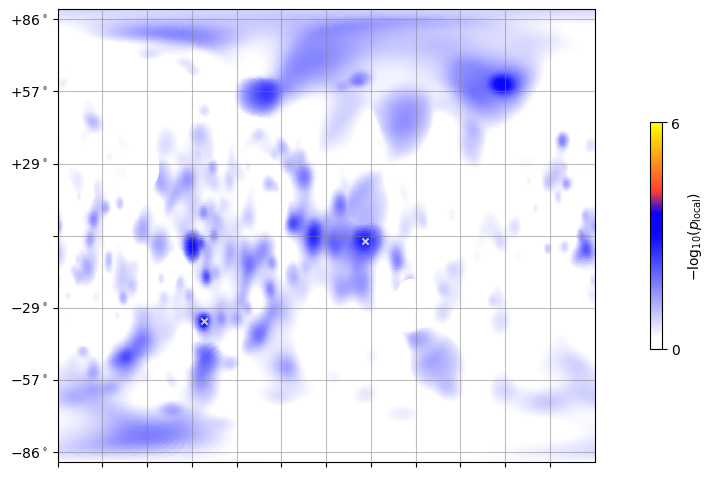

In [20]:
skymap_plotter = SkymapPlotter(
    skymap=ss_trial[0], label=r'$-\log_{10}(p_\mathrm{local})$', vmin=0, vmax=6, coord='G',
    gp_kw=dict(color='0.3', alpha=0.5), n_cb_ticks=2, gp_lw=1.)
#skymap_plotter.plot_catalog(marker='x', color='k')
skymap_plotter.plot_hotspots(marker='x', color='0.8', s=20)
#skymap_plotter.fig.savefig('{}/skymap_pvalues.png'.format(plot_dir))


#### Plot N-sigmas

In [21]:
import cv2

In [22]:
gp_gamma = cv2.imread('images/Fermi_144_month_all-sky-cyl_4000x2000.png')
gp_gamma = cv2.cvtColor(gp_gamma, cv2.COLOR_BGR2RGB)

In [23]:
#fermi = hp.fitsfunc.read_map('images/mapfermi.fits')

In [24]:
import astropy.io.fits as pf
from astropy.visualization import make_lupton_rgb

In [25]:
def treatImg(img, maxval=1, minval=0, q=1):    
    zerosup = img - np.percentile(img, q)
    zerosup[zerosup < 0] = minval
    
    maxperc = np.percentile(zerosup, 100-q)
    maximg = maxval * zerosup / maxperc
    
    maximg[maximg > maxval] = maxval
    
    return maximg.astype(np.float64)

In [26]:
hd = pf.open("images/mwpan2_RGB_3600.fits")
opt_image = make_lupton_rgb(treatImg(hd[0].data[2]), treatImg(hd[0].data[1]), treatImg(hd[0].data[0]), stretch=0.6, Q=2)


(1111.0, 889.0)

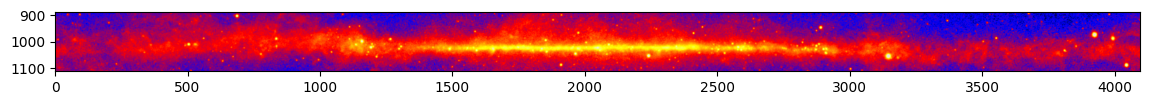

In [27]:
fig, ax = plt.subplots(figsize=(14,2))
ax.imshow(gp_gamma)
ax.set_ylim(1111, 1000-111)


In [28]:
ss_nsigmas =  stats.norm.isf(10**-ss_trial[0])
mask_pole = ss_trial[3] == 0.
ss_nsigmas[mask_pole] = np.nan

In [29]:
cmap = plt.cm.RdBu_r  # define the colormap
N_colors = cmap.N // 2
#print('N_colors', N_colors)
cmaplist = [cmap(i) for i in range(N_colors, cmap.N)]
cmaplist[0] = (1., 1., 1., 1.) # force first bin to be completely white

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0, 4, 9)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


In [48]:
def plot_mw(fig, ax, image='optical', ylim=10, vmax=1, label='', add_circle=False, cb=True, **kwargs):
    if image == 'optical':
        ax.imshow(opt_image, origin='lower', extent=[-180, 180, -90,90], aspect='auto', rasterized=True)
        ax.set_ylim(-ylim,ylim)
        #ax.set_xticklabels([0])
        ax.set_xticks((np.arange(-180, 181,60)))
        ax.set_yticks([15,0,-15])
        ax.set_yticklabels([r'15$^\circ$', r'0$^\circ$', r'-15$^\circ$'])
        ax.set_ylabel('Latitude [$b$]')
        if ylim == 10:
            txt = ax.text(-178, 6, label , color='w', alpha=1)
        elif ylim == 15:
            txt = ax.text(-178, 10, label , color='w', alpha=1)
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])

    elif image == 'gamma':
        ax.imshow(gp_gamma, origin='lower', extent=[-180, 180, 90,-90], aspect='auto', rasterized=True)
        ax.set_ylim(-ylim,ylim)
        #ax.set_xticklabels([0])
        ax.set_xticks((np.arange(-180, 181,60)))
        ax.set_yticks([15,0,-15])
        ax.set_yticklabels([r'15$^\circ$', r'0$^\circ$', r'-15$^\circ$'])
        ax.set_ylabel('Latitude [$b$]')
        if ylim == 10:
            txt = ax.text(-178, 6, label , color='w', alpha=1)
        elif ylim == 15:
            txt = ax.text(-178, 10, label , color='w', alpha=1)
            txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
    elif image == 'template':
        ax.set_yticks([np.radians(-15),np.radians(0),np.radians(15)])
        #ax.set_yticklabels('-15','0','15')
        ax.set_ylabel('Latitude [$b$]')
        if 'template_str' in kwargs.keys():
            template_str = kwargs['template_str']
        else:
            template_str = 'pi0'
        if 'smearing' in kwargs.keys():
            smearing = kwargs['smearing']
        else:
            smearing = 0 
        coord = 'G'
        template = get_smeared_template(template_str, smearing=smearing)
        template_plotter = SkymapPlotter(fig=fig, ax=ax, vmin=0, vmax=vmax,
            skymap=template, cmap='viridis',
            coord=coord, 
        )
        ax.set_ylim(np.radians(-ylim),np.radians(ylim))
        ax.set_yticklabels([r'-15$^\circ$', r'0$^\circ$', r'15$^\circ$'])
        ax.set_xticks(np.radians(np.arange(-180, 181,60)))
        if add_circle:
            circle1 = plt.Circle((np.radians(-165), np.radians(-3)), np.radians(7), color='w', fill=False, ls=':')
            ax.text(np.radians(-156), np.radians(-3), 'Typical Event Uncertainty', size=12, c='w')
            ax.add_patch(circle1)
        if ylim == 10:
            txt = ax.text(np.radians(-178), np.radians(5), label , color='w', alpha=1, )
            txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
            ax.text(np.radians(146), np.radians(5), 'Northern Sky', size=12, c='w' , rotation_mode='default')
            ax.text(np.radians(120), np.radians(-7), 'Southern Sky', size=12, c='w', rotation_mode='default')
        elif ylim == 15:
            txt = ax.text(np.radians(-178), np.radians(9), label , color='w', alpha=1, )
            txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
            if 'Predicted $\pi^0$' in label:
                ax.text(np.radians(144), np.radians(9), 'Northern Sky', size=13, c='w' , rotation_mode='default')
                ax.text(np.radians(115), np.radians(-12), 'Southern Sky', size=13, c='w', rotation_mode='default')
                ax.text(np.radians(-67), np.radians(9), 'Northern Sky', size=13, c='w' , rotation_mode='default')
                ax.text(np.radians(-35), np.radians(-12), 'Southern Sky', size=13, c='w', rotation_mode='default')
        if 'contour' in kwargs:
            if kwargs['contour']:
                smearing_deg = 7
                template_plotter.plot_template_contour('pi0', quantiles=[0.2, 0.5], color=['0.5', '0.3'], ls=['--', '-.'], smearing_deg=smearing_deg)
        template_plotter.draw_equator()
        template_plotter.cb.remove()
        ax.grid(None)
        #plotter = kwargs['plotter']
        #if cb:
        #    fig.colorbar(template_plotter.mesh, cax=ax,  shrink=0.5, orientation='vertical')
        return template_plotter
        
    elif image == 'results':
        nsigma_plotter = SkymapPlotter(fig=fig, ax=ax, 
                               skymap=ss_nsigmas, cmap=cmap, norm=norm, coord='G')

        ax.set_ylim(np.radians(-ylim), np.radians(ylim))
        ax.set_yticks([np.radians(-15),np.radians(0),np.radians(15)])
        ax.set_yticklabels([r'-15$^\circ$', r'0$^\circ$', r'15$^\circ$'])
        nsigma_plotter.draw_equator(color='grey')

        nsigma_plotter.cb.remove()
        ax.grid(None)
        if 'contour' in kwargs:
            if kwargs['contour']:
                smearing_deg = 7
                nsigma_plotter.plot_template_contour('pi0', quantiles=[0.2, 0.5], color=['0.5', '0.3'], 
                                                     ls=['--', '-.'], smearing_deg=smearing_deg)
        txt = ax.text(np.radians(-178), np.radians(10), r'$\nu$ Observed' , color='w', alpha=1, )
        if ylim == 10:
            txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
            ax.text(np.radians(75), np.radians(-12), 'Galactic Coord.', size=12, c='0.2' , rotation_mode='default')
            ax.text(np.radians(144), np.radians(1), 'Northern Sky', size=12, c='0.2' , rotation_mode='default')
            ax.text(np.radians(122), np.radians(-12), 'Southern Sky', size=12, c='0.2', rotation_mode='default')
        elif ylim == 15:
            txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='k')])
            ax.text(np.radians(75), np.radians(9), 'Galactic Coord.', size=12, c='0.2' , rotation_mode='default')
            #ax.text(np.radians(144), np.radians(9), 'Northern Sky', size=12, c='0.2' , rotation_mode='default')
            #ax.text(np.radians(115), np.radians(-12), 'Southern Sky', size=12, c='0.2', rotation_mode='default')
        ax.set_xticks(np.radians(np.arange(-180, 181,60)))
        ax.set_xticklabels([r'180$^\circ$', r'120$^\circ$', '60$^\circ$', '$0^\circ$','-60$^\circ$', '-120$^\circ$', '-180$^\circ$'])
        ax.set_xlabel('Galactic Longitude [$l$]')
        ax.set_ylabel('Latitude [$b$]')
    elif image == 'cb':
        plotter = kwargs['plotter']
        #cb = fig.colorbar(plotter.mesh,  cax=ax, shrink=0.3, orientation='horizontal')
        cb = fig.colorbar(plotter.mesh, pad=0, cax=ax, use_gridspec=True,orientation='vertical')
        cb.set_label(label)
        if kwargs['cb_ticks']:
            cb.set_ticks(kwargs['cb_ticks'])
    if image == 'results':
        ax.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=True,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off 
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=True,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=True) # labels along the bottom edge are off

    elif image != 'cb':
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=True,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        ax.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=True,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off    
    
    if image == 'results':
        return nsigma_plotter

/mnt/ceph1-npx/user/ssclafani/software/external/csky/csky/plotting.py:356: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolormesh(lon, lat, Z, **kw)
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


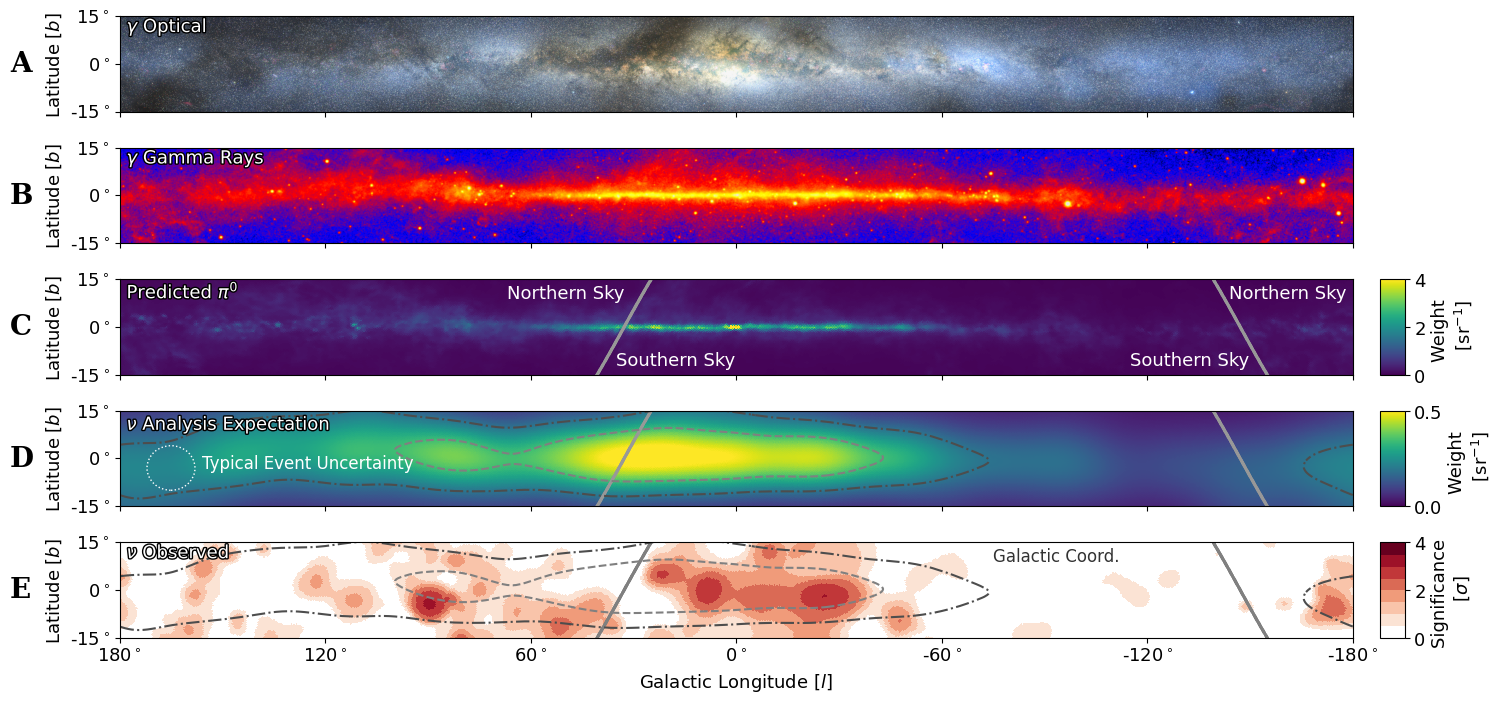

In [31]:
## figsize=(19,10.2)
mpl.rc('font', size=13)
fig = plt.figure(figsize=(15,7.2), constrained_layout=True)
gs = fig.add_gridspec(5,2,  height_ratios=[2, 2, 2, 2, 2],
                     width_ratios=[5,.1])
#gs.update(wspace=0.005)
#gs.tight_layout
cb_axis_3 = fig.add_subplot(gs[2,1])
cb_axis_4 = fig.add_subplot(gs[3,1])
cb_axis_5 = fig.add_subplot(gs[4,1])
left_axes = [fig.add_subplot(gs[i, 0]) for i in range(5)]
#right_axes = [fig.add_subplot(gs[i, 1]) for i in [3,4,5]]

#fig, axs = plt.subplots(5,1, figsize=(10,6), gridspec_kw={'height_ratios': [2,2,2,3,3]})
plot_mw(fig, left_axes[0], image='optical', label='$\gamma$ Optical', ylim=15)
left_axes[0].text(-212,0, 'A', verticalalignment='center',fontdict={'fontweight' : 'bold',
                                   'fontsize' : 20,
                                   'fontfamily' : 'serif'})
plot_mw(fig, left_axes[1], image='gamma', label= '$\gamma$ Gamma Rays' , ylim=15)
left_axes[1].text(-212,0, 'B', verticalalignment='center',fontdict={'fontweight' : 'bold',
                                   'fontsize' : 20,
                                   'fontfamily' : 'serif'})

predicted_plotter = plot_mw(fig, left_axes[2], image='template', ylim=15,  label=r'Predicted $\pi^0$', 
                            template_str='pi0', vmax=4)
plot_mw(fig, ax=cb_axis_3, image='cb', plotter=predicted_plotter, label='Weight \n [sr$^{-1}$]', cb_ticks=[0.0,2.0,4.0])

left_axes[2].text(np.radians(-212),0, 'C',verticalalignment='center', fontdict={'fontweight' : 'bold',
                                   'fontsize' : 20,
                                   'fontfamily' : 'serif'})

template_exp = plot_mw(fig, left_axes[3], image='template', ylim=15, label= r'$\nu$ Analysis Expectation', 
                       contour=True, template_str='pi0', smearing=7, vmax=.5, add_circle=True)
plot_mw(fig, ax=cb_axis_4, image='cb', plotter=template_exp, label='Weight \n [sr$^{-1}$]', cb_ticks=[0,.5])
left_axes[3].text(np.radians(-212),0, 'D', verticalalignment='center',fontdict={'fontweight' : 'bold',
                                                'fontsize' : 20,
                                   'fontfamily' : 'serif'})

nsigma_plotter = plot_mw(fig, left_axes[4], image='results', ylim=15, contour=True, smearing=7,)
plot_mw(fig, ax=cb_axis_5, image='cb', plotter=nsigma_plotter, label='Significance \n [$\sigma$]', cb_ticks=[0,2,4])
left_axes[4].text(np.radians(-212),0,  'E',verticalalignment='center', fontdict={'fontweight' : 'bold',
                                   'fontsize' : 20,
                                   'fontfamily' : 'serif'})
#gs.tight_layout()
#gs.update(wspace=0.00002)
'''gs.tight_layout(
    fig,
    renderer=None,
    pad=0,
    h_pad=0,
    w_pad=.05,
    rect=None,
)'''
plt.tight_layout(pad=1.0, w_pad = 1.5)
plt.savefig('{}/fig1_rev1.pdf'.format(plot_dir) )


/mnt/ceph1-npx/user/ssclafani/software/external/csky/csky/plotting.py:356: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolormesh(lon, lat, Z, **kw)
/mnt/ceph1-npx/user/ssclafani/software/external/csky/csky/plotting.py:356: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolormesh(lon, lat, Z, **kw)
/home/ssclafani/.vens/py3_venv/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: This figure was using constrained_layout==True

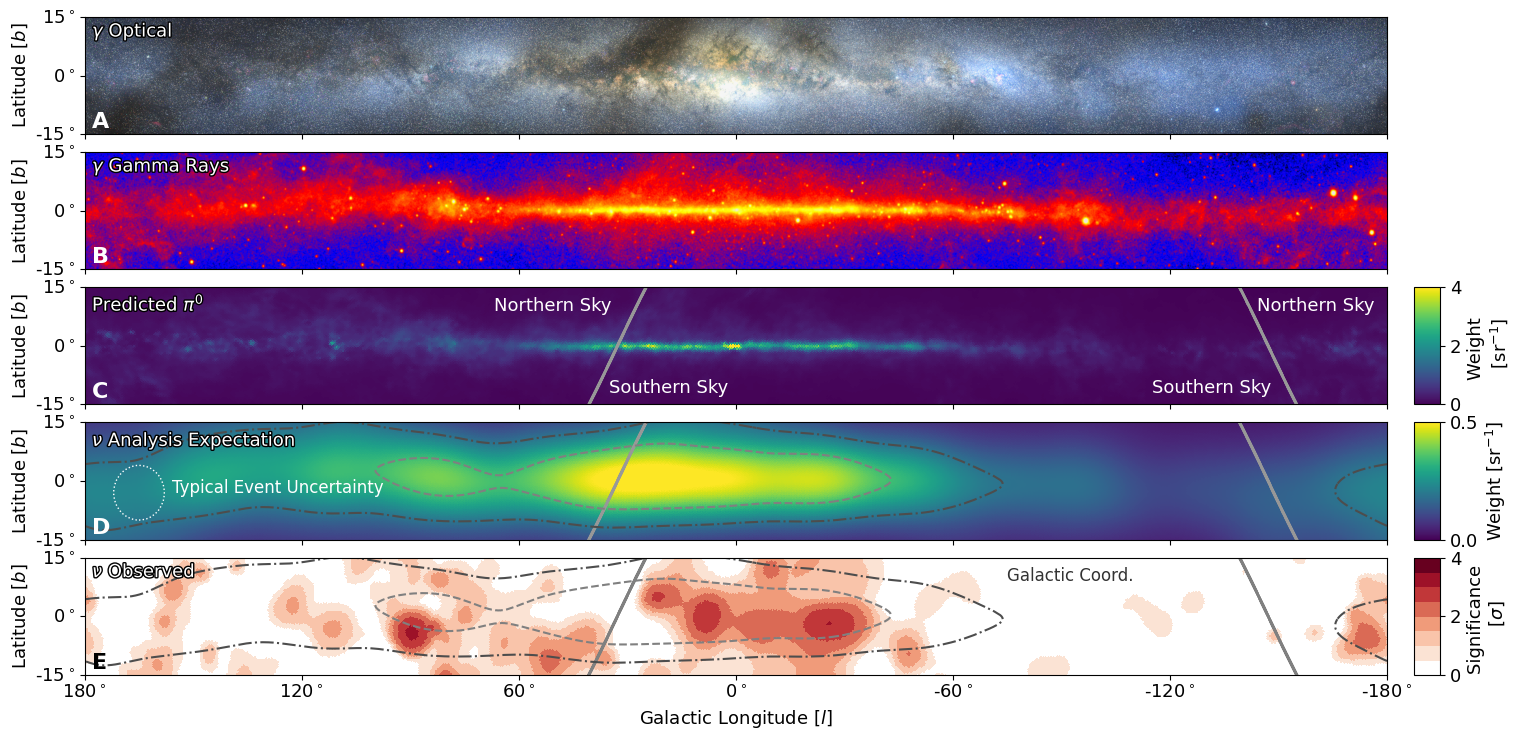

In [49]:
## figsize=(19,10.2)
mpl.rc('font', size=13)
fig = plt.figure(figsize=(15,7.2), constrained_layout=True)
gs = fig.add_gridspec(5,2,  height_ratios=[2, 2, 2, 2, 2],
                     width_ratios=[5,.1])
#gs.update(wspace=0.005)
#gs.tight_layout
cb_axis_3 = fig.add_subplot(gs[2,1])
cb_axis_4 = fig.add_subplot(gs[3,1])
cb_axis_5 = fig.add_subplot(gs[4,1])
left_axes = [fig.add_subplot(gs[i, 0]) for i in range(5)]
#right_axes = [fig.add_subplot(gs[i, 1]) for i in [3,4,5]]

#fig, axs = plt.subplots(5,1, figsize=(10,6), gridspec_kw={'height_ratios': [2,2,2,3,3]})
panelx = -178
plot_mw(fig, left_axes[0], image='optical', label='$\gamma$ Optical', ylim=15)
left_axes[0].text(panelx,-14.5, 'A', verticalalignment='bottom', color='w', fontdict={'fontweight' : 'bold',
                                   'fontsize' : 16})
plot_mw(fig, left_axes[1], image='gamma', label= '$\gamma$ Gamma Rays' , ylim=15)
left_axes[1].text(panelx,-14.5, 'B', verticalalignment='bottom', color='w',fontdict={'fontweight' : 'bold',
                                   'fontsize' : 16})

predicted_plotter = plot_mw(fig, left_axes[2], image='template', ylim=15,  label=r'Predicted $\pi^0$', 
                            template_str='pi0', vmax=4)
plot_mw(fig, ax=cb_axis_3, image='cb', plotter=predicted_plotter, label='Weight \n [sr$^{-1}$]', cb_ticks=[0.0,2.0,4.0])

left_axes[2].text(np.radians(panelx),np.radians(-14.5), 'C',verticalalignment='bottom', color='w', fontdict={'fontweight' : 'bold',
                                   'fontsize' : 16})

template_exp = plot_mw(fig, left_axes[3], image='template', ylim=15, label= r'$\nu$ Analysis Expectation', 
                       contour=True, template_str='pi0', smearing=7, vmax=.5, add_circle=True)
plot_mw(fig, ax=cb_axis_4, image='cb', plotter=template_exp, label='Weight [sr$^{-1}$]', cb_ticks=[0,.5])
left_axes[3].text(np.radians(panelx),np.radians(-14.5), 'D', verticalalignment='bottom', color='w',fontdict={'fontweight' : 'bold',
                                                'fontsize' : 16})

nsigma_plotter = plot_mw(fig, left_axes[4], image='results', ylim=15, contour=True, smearing=7,)
plot_mw(fig, ax=cb_axis_5, image='cb', plotter=nsigma_plotter, label='Significance \n [$\sigma$]', cb_ticks=[0,2,4])
left_axes[4].text(np.radians(panelx),np.radians(-14.5),  'E',verticalalignment='bottom', color='k', fontdict={'fontweight' : 'bold',
                                   'fontsize' : 16})
#gs.tight_layout()
#gs.update(wspace=0.00002)
'''gs.tight_layout(
    fig,
    renderer=None,
    pad=0,
    h_pad=0,
    w_pad=.05,
    rect=None,
)'''
plt.tight_layout(pad=0, w_pad = 1.5)
plt.savefig('{}/fig1.pdf'.format(plot_dir) )


/mnt/ceph1-npx/user/ssclafani/software/external/csky/csky/plotting.py:356: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolormesh(lon, lat, Z, **kw)
/mnt/ceph1-npx/user/ssclafani/software/external/csky/csky/plotting.py:356: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolormesh(lon, lat, Z, **kw)


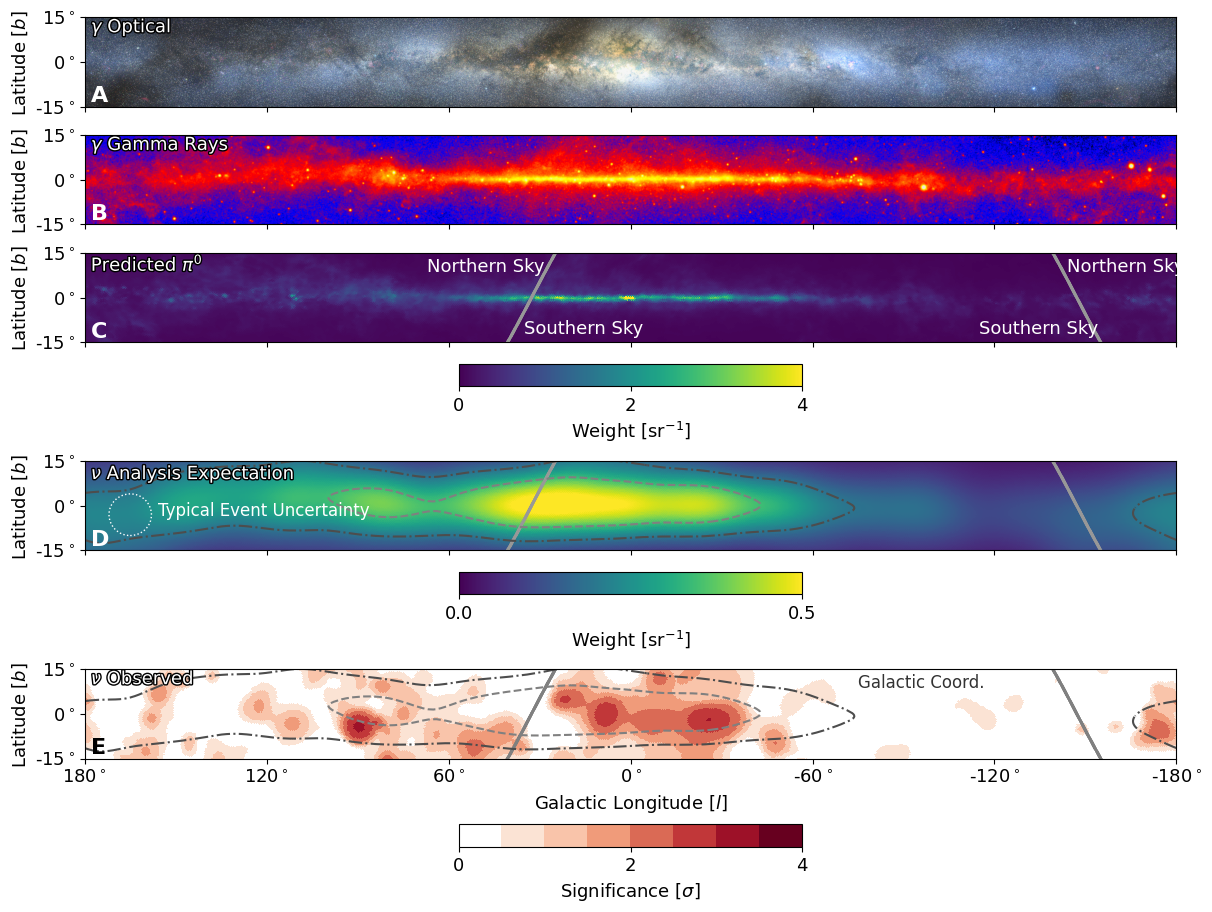

In [47]:
## figsize=(19,10.2)
mpl.rc('font', size=13)
fig = plt.figure(figsize=(13,9), constrained_layout=True)
gs = fig.add_gridspec(8,3,  height_ratios=[2, 2, 2, 0.5, 2,0.5,2,0.5], width_ratios=[3,3,3])
#gs.update(wspace=0.005)
#gs.tight_layout
cb_axis_3 = fig.add_subplot(gs[3,1])
cb_axis_4 = fig.add_subplot(gs[5,1])
cb_axis_5 = fig.add_subplot(gs[7,1])
left_axes = [fig.add_subplot(gs[i, :]) for i in [0,1,2,4,6]]
#right_axes = [fig.add_subplot(gs[i, 1]) for i in [3,4,5]]

#fig, axs = plt.subplots(5,1, figsize=(10,6), gridspec_kw={'height_ratios': [2,2,2,3,3]})
panelx = -178
plot_mw(fig, left_axes[0], image='optical', label='$\gamma$ Optical', ylim=15)
left_axes[0].text(panelx,-14.5, 'A', verticalalignment='bottom', color='w', fontdict={'fontweight' : 'bold',
                                   'fontsize' : 16})
plot_mw(fig, left_axes[1], image='gamma', label= '$\gamma$ Gamma Rays' , ylim=15)
left_axes[1].text(panelx,-14.5, 'B', verticalalignment='bottom', color='w',fontdict={'fontweight' : 'bold',
                                   'fontsize' : 16})

predicted_plotter = plot_mw(fig, left_axes[2], image='template', ylim=15,  label=r'Predicted $\pi^0$', 
                            template_str='pi0', vmax=4)
plot_mw(fig, ax=cb_axis_3, image='cb', plotter=predicted_plotter, label='Weight [sr$^{-1}$]', cb_ticks=[0.0,2.0,4.0])

left_axes[2].text(np.radians(panelx),np.radians(-14.5), 'C',verticalalignment='bottom', color='w', fontdict={'fontweight' : 'bold',
                                   'fontsize' : 16})

template_exp = plot_mw(fig, left_axes[3], image='template', ylim=15, label= r'$\nu$ Analysis Expectation', 
                       contour=True, template_str='pi0', smearing=7, vmax=.5, add_circle=True)
plot_mw(fig, ax=cb_axis_4, image='cb', plotter=template_exp, label='Weight [sr$^{-1}$]', cb_ticks=[0,.5])
left_axes[3].text(np.radians(panelx),np.radians(-14.5), 'D', verticalalignment='bottom', color='w',fontdict={'fontweight' : 'bold',
                                                'fontsize' : 16})

nsigma_plotter = plot_mw(fig, left_axes[4], image='results', ylim=15, contour=True, smearing=7,)
plot_mw(fig, ax=cb_axis_5, image='cb', plotter=nsigma_plotter, label='Significance [$\sigma$]', cb_ticks=[0,2,4])
left_axes[4].text(np.radians(panelx),np.radians(-14.5),  'E',verticalalignment='bottom', color='k', fontdict={'fontweight' : 'bold',
                                   'fontsize' : 16})
#gs.tight_layout()
#gs.update(wspace=0.00002)
'''gs.tight_layout(
    fig,
    renderer=None,
    pad=0,
    h_pad=0,
    w_pad=.05,
    rect=None,
)'''
#plt.tight_layout(pad=1.0, w_pad = 1.5)
plt.savefig('{}/fig1_horizontal.pdf'.format(plot_dir) )


In [ ]:
mpl.rc('font', size=12)
fig = plt.figure(figsize=(14,7.2), constrained_layout=True)
gs = fig.add_gridspec(5,2, wspace=0.05, height_ratios=[2, 2, 2, 2, 2],
                     width_ratios=[5,.1])
gs.tight_layout?

In [34]:

mpl.rc('font', size=12)
fig = plt.figure(figsize=(15,7)) #, constrained_layout=True)
gs = fig.add_gridspec(5, 1, height_ratios=[2, 2, 2, 3, ],
                     width_ratios=[1])
#cb_axis = fig.add_subplot(gs[-1,1])
axes = [fig.add_subplot(gs[i, :]) for i in range(5)]

#fig, axs = plt.subplots(5,1, figsize=(18,6), gridspec_kw={'height_ratios': [2,2,2,3,3]})
plot_mw(fig, axes[0], image='optical', label='$\gamma$ Optical', ylim=10)
plot_mw(fig, axes[1], image='gamma', label= '$\gamma$ HE' , ylim=10)
plot_mw(fig, axes[2], image='template', ylim=10,  label=r'$\nu$ Predicted $\pi^0$', template_str='pi0', vmax=4)
plot_mw(fig, axes[3], image='template', ylim=15, label= r'$\nu$ Analysis Expectation', contour=True, template_str='pi0', smearing=7, vmax=.5)
nsigma_plotter = plot_mw(fig, axes[4], image='results', ylim=15, contour=True, smearing=7,)
#plot_mw(fig, ax=cb_axis, image='cb', plotter=nsigma_plotter)
#plt.tight_layout()
plt.savefig('{}/template_galactic_pi0_effect_smearing_contour_result_contour.pdf'.format(plot_dir), bbox_inches='tight')


ValueError: Expected the given number of height ratios to match the number of rows of the grid

<Figure size 1500x700 with 0 Axes>

In [ ]:

mpl.rc('font', size=12)
fig = plt.figure(figsize=(12,7)) #, constrained_layout=True)
gs = fig.add_gridspec(6, 3, height_ratios=[3, 3, 3, 3, 3, 0.5],
                     width_ratios=[1, 1, 1])
cb_axis = fig.add_subplot(gs[-1,1])
axes = [fig.add_subplot(gs[i, :]) for i in range(5)]

#fig, axs = plt.subplots(5,1, figsize=(18,6), gridspec_kw={'height_ratios': [2,2,2,3,3]})
plot_mw(fig, axes[0], image='optical', label='$\gamma$ Optical', ylim=15)
plot_mw(fig, axes[1], image='gamma', label= '$\gamma$ HE' , ylim=15)
plot_mw(fig, axes[2], image='template', ylim=15,  label=r'$\nu$ Predicted $\pi^0$', template_str='pi0', vmax=4)
plot_mw(fig, axes[3], image='template', ylim=15, label= r'$\nu$ Analysis Expectation', contour=True, template_str='pi0', smearing=7, vmax=.5, add_circle=True)
nsigma_plotter = plot_mw(fig, axes[4], image='results', ylim=15, contour=True, smearing=7,)
plot_mw(fig, ax=cb_axis, image='cb', plotter=nsigma_plotter, pad=0.3)
if embargo_label:
    plt.text(-np.pi+.1,-.2, r'Under Embargo, Not For Proceedings', 
             weight='bold', c='r', alpha=1,size=12)
plt.tight_layout()
plt.savefig('{}/template_galactic_all_15_lowres'.format(plot_dir), bbox_inches='tight', dpi=50)


In [ ]:

mpl.rc('font', size=12)
fig = plt.figure(figsize=(12,2.75)) #, constrained_layout=True)
gs = fig.add_gridspec(3, 3, height_ratios=[ 3, 0.25, 0.25],
                     width_ratios=[1, 1, 1])
cb_axis = fig.add_subplot(gs[-1,1])
axes = [fig.add_subplot(gs[i, :]) for i in range(1)]

#fig, axs = plt.subplots(5,1, figsize=(18,6), gridspec_kw={'height_ratios': [2,2,2,3,3]})
#plot_mw(fig, axes[0], image='optical', label='$\gamma$ Optical', ylim=15)
#plot_mw(fig, axes[1], image='gamma', label= '$\gamma$ HE' , ylim=15)
#plot_mw(fig, axes[2], image='template', ylim=15,  label=r'$\nu$ Predicted $\pi^0$', template_str='pi0', vmax=4)
#plot_mw(fig, axes[3], image='template', ylim=15, label= r'$\nu$ Analysis Expectation', contour=True, template_str='pi0', smearing=7, vmax=.5, add_circle=True)
nsigma_plotter = plot_mw(fig, axes[0], image='results', ylim=15, contour=True, smearing=7,)
plot_mw(fig, ax=cb_axis, image='cb', plotter=nsigma_plotter, pad=0.5)
if embargo_label:
    plt.text(-np.pi+.1,-.2, r'Under Embargo, Not For Proceedings', 
             weight='bold', c='r', alpha=1,size=12)
plt.tight_layout()
plt.savefig('{}/template_galactic_result_only'.format(plot_dir), bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()
template = get_smeared_template('pi0', smearing=0)
template_plotter = SkymapPlotter(fig=fig, ax=ax, vmin=0, vmax=5,
            skymap=template, cmap='viridis',
            coord='G', 
        )
cb = template_plotter.cb
